### TYK2 Normalization Condition: IFN-Beta vs Untreated

We have seen that normalizing our primary, IFN-alpha- or drug-treated samples to IFN-beta or Untreated produces meaningfully distinct results. Generally (though not perfectly), normalization to Untreated results in a significant hit list that is slightly smaller, and for drug-treated comparisons nearly a subset, than that for IFN-beta. To better understand these differences, we focus here on the comparisons involving `IFNalphaWithDrug100`, as that was the comparison that motivated this analysis. To start, let's extract all significant variants from `IFNalphaWithDrug100 - IFNbeta100` or `IFNalphaWithDrug100 - None0` and compare them:

In [51]:
library(ggpubr)
library(fs)
library(patchwork)
library(pheatmap)
library(tidyverse)

In [3]:
sumstats <- read_tsv("../sumstats/tyk2_full_comparisons.tsv") %>% filter(!chunk %in% c(9,16))

drug_comparisons <- sumstats %>%
    filter(grepl("WithDrug", condition))

Rows: 236490 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): clone, chunk, aa, version, condition
dbl (7): pos, log2FoldChange, std.error, dispersion, statistic, p.value, p.adj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [86]:
lfc_compare <- drug_comparisons %>% 
    select(pos, aa, log2FoldChange, condition, p.adj) %>%
    mutate(condition = gsub("IFNalphaWithDrug100 - ", "", condition)) %>% 
    pivot_wider(names_from = c(condition), values_from = c(log2FoldChange, p.adj)) %>%
    mutate(color = case_when(p.adj_None0 < 0.01 & p.adj_IFNbeta100 < 0.01 ~ "red",
                             p.adj_None0 < 0.01 ~ "purple",
                             p.adj_IFNbeta100 < 0.01 ~ "darkgreen",
                             TRUE ~ "gray"),
           alpha = if_else(p.adj_None0 < 0.01 | p.adj_IFNbeta100 < 0.01, 1, 0.3)) %>%
    ggplot() +
        geom_point(aes(x = log2FoldChange_None0, y = log2FoldChange_IFNbeta100,
                       alpha = alpha, color = color)) +
        theme_pubr(base_size = 16) +
        scale_color_identity() + scale_alpha_identity() +
        xlab("Log2FoldChange, Treated vs Untreated") + 
        ylab("Log2FoldChange, Treated vs IFN-beta") +
        xlim(c(-4,4)) + ylim(c(-4,4)) +
        geom_abline(slope = 1, intercept = 0)

stat_compare <- drug_comparisons %>% 
    select(pos, aa, statistic, condition, p.adj) %>%
    mutate(condition = gsub("IFNalphaWithDrug100 - ", "", condition)) %>% 
    pivot_wider(names_from = c(condition), values_from = c(statistic, p.adj)) %>%
    mutate(color = case_when(p.adj_None0 < 0.01 & p.adj_IFNbeta100 < 0.01 ~ "red",
                             p.adj_None0 < 0.01 ~ "purple",
                             p.adj_IFNbeta100 < 0.01 ~ "darkgreen",
                             TRUE ~ "gray"),
           alpha = if_else(p.adj_None0 < 0.01 | p.adj_IFNbeta100 < 0.01, 1, 0.3)) %>%
    ggplot() +
        geom_point(aes(x = statistic_None0, y = statistic_IFNbeta100,
                       alpha = alpha, color = color)) +
        theme_pubr(base_size = 16) +
        scale_color_identity() + scale_alpha_identity() +
        xlab("Z-Statistic, Treated vs Untreated") + 
        ylab("Z-Statistic, Treated vs IFN-beta") +
        xlim(c(-5,10)) + ylim(c(-5,10)) +
        geom_abline(slope = 1, intercept = 0)

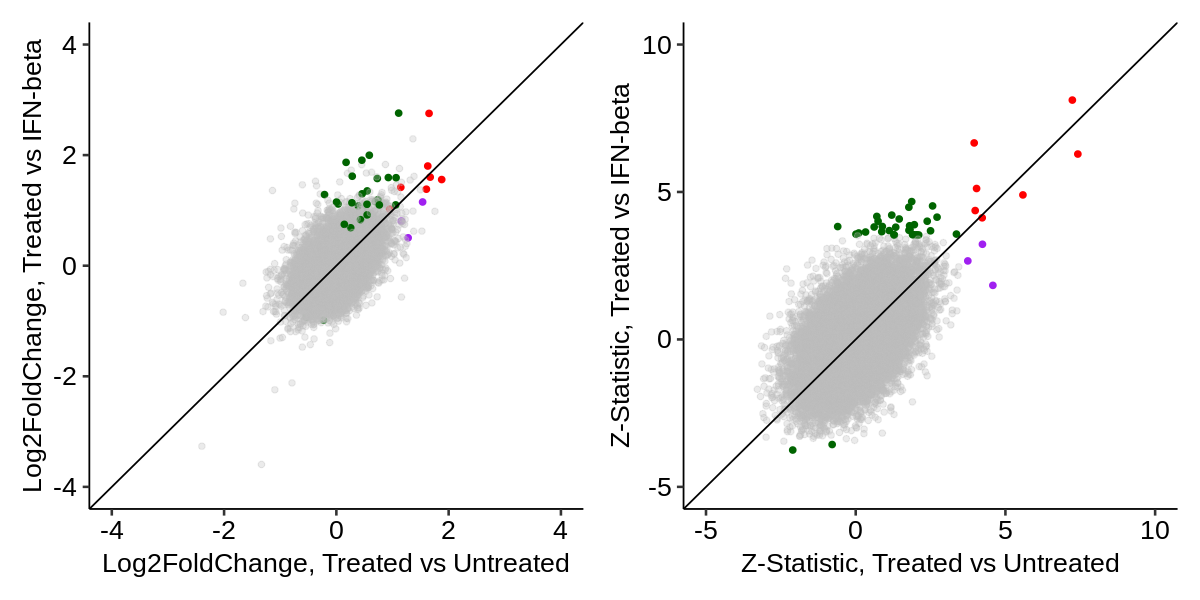

In [87]:
options(repr.plot.width = 10, repr.plot.height = 5)
lfc_compare + stat_compare

In [43]:
raw_sumstats <- dir_ls("../sumstats/TYK2/run3/", glob = "*-combined.sumstats.tsv") %>%
    map_dfr(read_tsv, col_types = "ncccnnnnc", na = "NA") %>% 
    filter(!chunk %in% c(9,16),
           grepl("aa",term),
           pos != 1188) %>%
    separate(term, c("condition", "aa"), ":") %>%
    mutate(condition = gsub("condition", "", condition),
           group = if_else(aa %in% c("mut_aa*", "mut_aaX"), chunk, "Non-Stop"),
           aa = gsub("mut_aa", "", aa),
           aa = if_else(aa %in% c("*","X"), "*", aa))

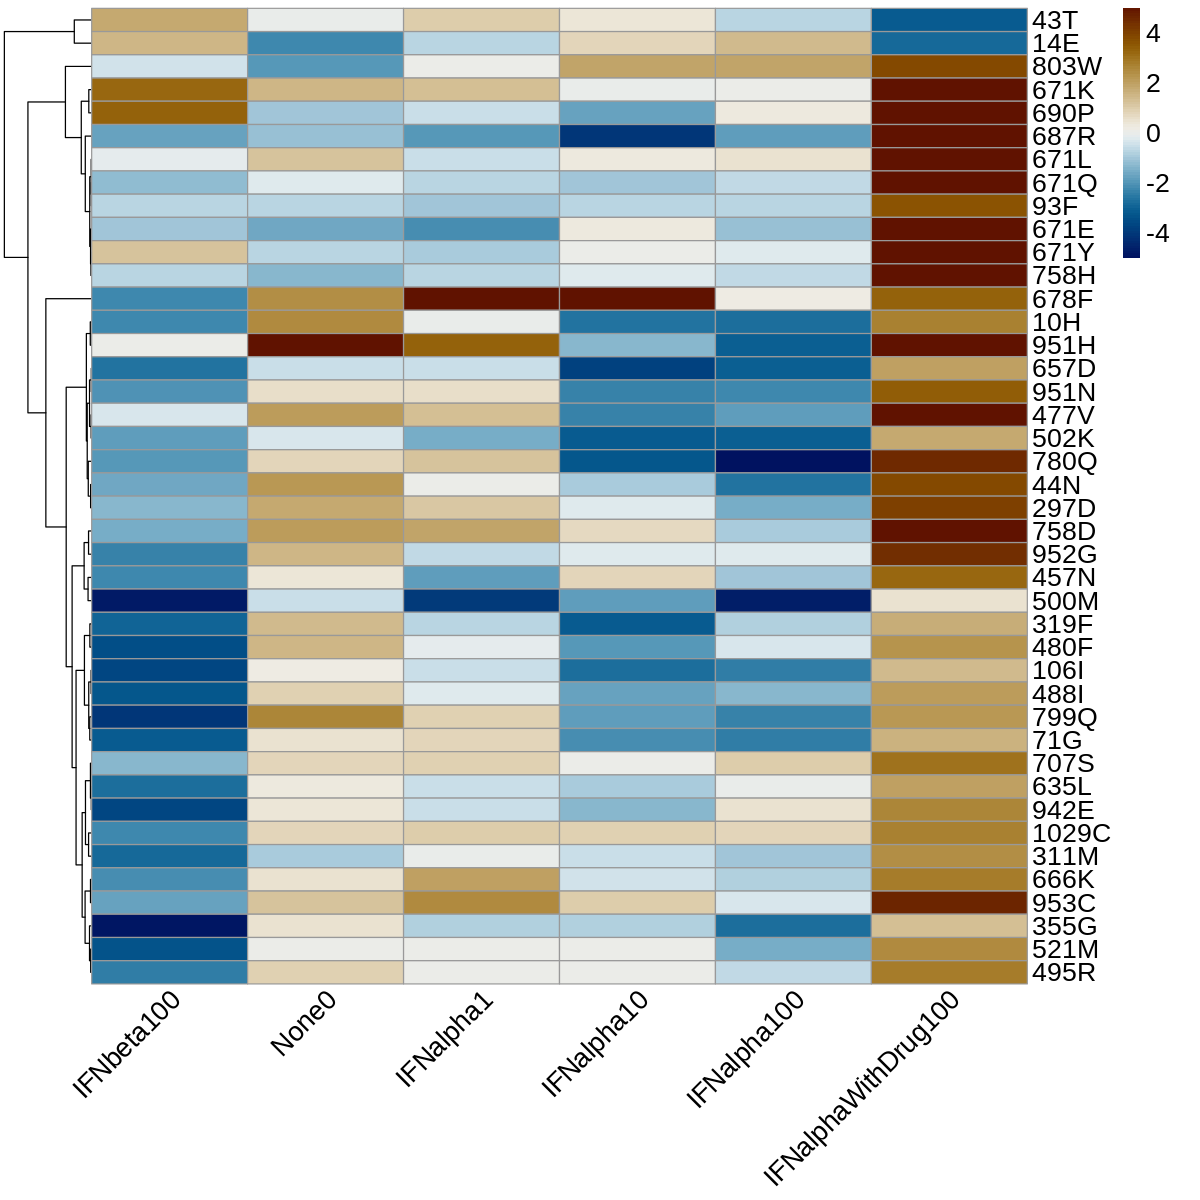

In [66]:
varset <- drug_comparisons %>%
    select(pos, aa, condition, statistic, p.adj) %>%
    mutate(condition = gsub("IFNalphaWithDrug100 - ", "", condition)) %>% 
    filter(p.adj < 0.01) %>%
    select(pos, aa) %>%
    distinct()

breaks <- seq(-5,5,length.out = 100)
colors <- scico::scico(100,palette = "vik")

varset_data <- raw_sumstats %>%
    filter(paste0(pos, aa) %in% paste0(varset$pos, varset$aa)) %>%
    mutate(mut = paste0(pos,aa)) %>%
    select(mut, statistic, condition) %>%
    pivot_wider(names_from = condition, values_from = statistic) %>%
    relocate(c(IFNbeta100, None0), .after = mut)

options(repr.plot.height = 10, repr.plot.wigth = 8)
pheatmap(varset_data[,-1],
         cluster_cols = FALSE,
         labels_row = varset_data[,1] %>% unlist(),
         angle_col = 45, fontsize = 16, breaks = breaks,
         color = colors,
         clustering_distance_rows = "correlation")

There is a set of variants (the core drug binding pocket, position 671 and others) which are similarly neutral in both IFN-beta and None. However, there is another class of variants which does appear elevated in IFNalpha100withDrug comapred to the other conditions, but which is also LoF within the IFN-beta condition alone. These borderline variants are the main class captured by IFN-beta normalization, but excluded by None-normalization.


Next, let's take these same variants and compute the difference between `None0` and `IFNbeta100`. We expect that some of these will be no different (particularly for variants which were significant in both `IFNalpha100withDrug - None0` and `IFNalpha100withDrug - IFNbeta100`:

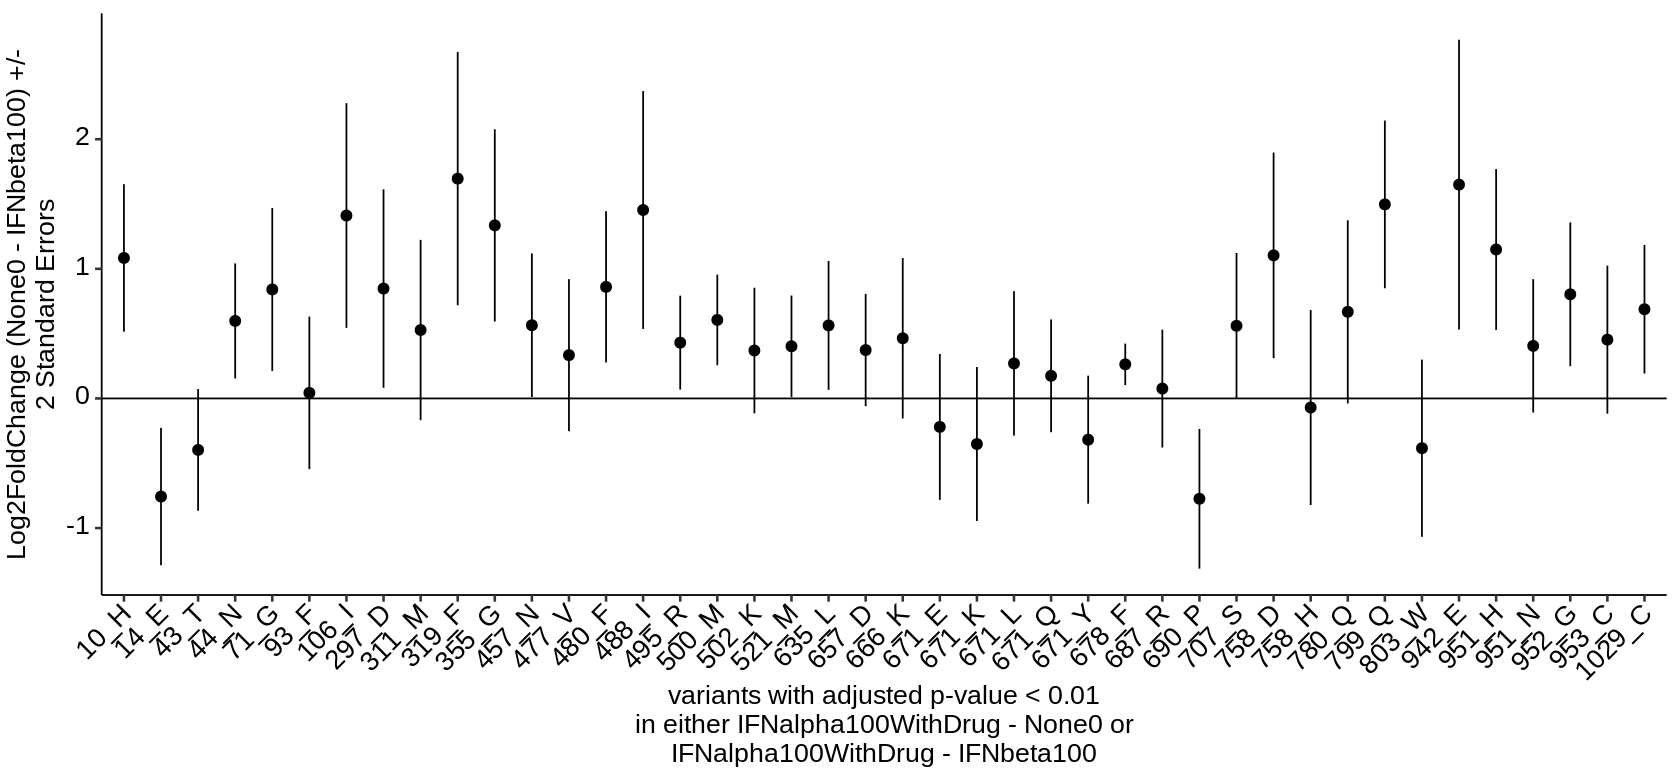

In [89]:
options(repr.plot.width = 14, repr.plot.height = 6.5)

sumstats %>%
    filter(condition == "None0 - IFNbeta100") %>%
    inner_join(varset, by = join_by(pos, aa)) %>% 
    ggplot() +
        geom_hline(yintercept = 0) +
        geom_pointrange(aes(x = reorder(str_c(pos, "_", aa), pos), y = log2FoldChange,
                            ymin = log2FoldChange - std.error*2,
                            ymax = log2FoldChange + std.error*2)) +
        theme_pubr(base_size = 16,x.text.angle = 45) +
        ylab("Log2FoldChange (None0 - IFNbeta100) +/-\n2 Standard Errors") +
        xlab("variants with adjusted p-value < 0.01\nin either IFNalpha100WithDrug - None0 or\nIFNalpha100WithDrug - IFNbeta100")

The positive effects above are significantly more active in `None0` compared to `IFNbeta100`, and thus are "basal activators" of the signaling pathway. In contrast, negative effects are much rarer and describe variants which suppress residual basal activity from WT. For TYK2, we know that residual WT basal activity is very low, so there is not much bandwidth to further lower it. That being said, 690P is notable for being both in the drug-binding area and having a borderline significant negative effect.